# Postprocessing and Model Building

In [3]:
import os
import pickle
import json
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns

In [4]:
with open('/projects/kernlab/akapoor/Demographic_Inference/moments_dadi_features/software_inferences_sim_3.pkl', 'rb') as f:
    test = pickle.load(f)

In [5]:
test['opt_params_dadi']

[{'N0': 8495.509614319324,
  'Nb': 7645.9586528873915,
  'N_recover': 6062.051717396926,
  't_bottleneck_end': 2641.46139062809,
  'll': 257.43524626225644},
 {'N0': 14463840.978358727,
  'Nb': 8494.84476311424,
  'N_recover': 6069.464869667707,
  't_bottleneck_end': 2892.768195671748,
  'll': 257.09768556275685}]

In [6]:
test['simulated_params']

{'N0': 8332,
 'Nb': 4607,
 'N_recover': 6217,
 't_bottleneck_start': 1828,
 't_bottleneck_end': 953}

In [7]:
main_filepath = '/projects/kernlab/akapoor/Demographic_Inference'

CONFIG_FILEPATH = f'{main_filepath}/experiment_config.json'
MODEL_CONFIG_FILEPATH = f'{main_filepath}/model_config.json'

with open(CONFIG_FILEPATH, 'r') as f:
   experiment_config = json.load(f)

with open(MODEL_CONFIG_FILEPATH, 'r') as f:
   model_config = json.load(f)


CWD = os.getcwd()

# Use double quotes for the dictionary keys inside the f-string
EXPERIMENT_DIRECTORY = f"{experiment_config['demographic_model']}_dadi_analysis_{experiment_config['dadi_analysis']}_moments_analysis_{experiment_config['moments_analysis']}_momentsLD_analysis_{experiment_config['momentsLD_analysis']}_seed_{experiment_config['seed']}"
EXPERIMENT_NAME = f'sims_pretrain_{experiment_config["num_sims_pretrain"]}_sims_inference_{experiment_config["num_sims_inference"]}_seed_{experiment_config["seed"]}_num_replicates_{experiment_config["k"]}_top_values_{experiment_config["top_values_k"]}'
SIM_DIRECTORY = f"{EXPERIMENT_DIRECTORY}/sims/{EXPERIMENT_NAME}"

# Check if hidden_size is a list, and if so, join the elements with "_"
hidden_size = model_config['neural_net_hyperparameters']['hidden_size']
if isinstance(hidden_size, list):
    hidden_size_str = "_".join(map(str, hidden_size))  # Join list elements with "_"
else:
    hidden_size_str = str(hidden_size)  # Convert integer to string if not a list

# Build the MODEL_DIRECTORY string
MODEL_DIRECTORY = (
    f"{EXPERIMENT_DIRECTORY}/models/{EXPERIMENT_NAME}/"
    f"num_hidden_neurons_{hidden_size_str}_"
    f"num_hidden_layers_{model_config['neural_net_hyperparameters']['num_layers']}_"
    f"num_epochs_{model_config['neural_net_hyperparameters']['num_epochs']}_"
    f"dropout_value_{model_config['neural_net_hyperparameters']['dropout_rate']}_"
    f"weight_decay_{model_config['neural_net_hyperparameters']['weight_decay']}_"
    f"batch_size_{model_config['neural_net_hyperparameters']['batch_size']}_"
    f"EarlyStopping_{model_config['neural_net_hyperparameters']['EarlyStopping']}"
)


In [8]:
os.chdir('/projects/kernlab/akapoor/Demographic_Inference/')
os.environ['PYTHONPATH'] = '/projects/kernlab/akapoor/Demographic_Inference:' + os.environ.get('PYTHONPATH', '')

Just to check again, I want to look at the results for preprocessing

In [9]:
with open(os.path.join('/projects/kernlab/akapoor/Demographic_Inference',f'{SIM_DIRECTORY}', 'preprocessing_results_obj.pkl'), 'rb') as f:
    preproc = pickle.load(f)

In [10]:
preproc['training']['indices'][0]

4227

In [11]:
preproc['training']['predictions']

,dadi_rep1_N0,moments_rep1_N0,moments_rep1_FIM_element_0,moments_rep1_FIM_element_1,moments_rep1_FIM_element_2,moments_rep1_FIM_element_3,moments_rep1_FIM_element_4,moments_rep1_FIM_element_5,dadi_rep1_Nb,moments_rep1_Nb,...,dadi_rep2_Nb,moments_rep2_Nb,dadi_rep2_N_recover,moments_rep2_N_recover,dadi_rep2_t_bottleneck_end,moments_rep2_t_bottleneck_end,momentsLD_N0,momentsLD_Nb,momentsLD_N_recover,momentsLD_t_bottleneck_end
0,7.418959e+07,8.387929e+03,0.276726,-0.254005,0.282219,0.398799,-0.201950,-0.287445,6.677063e+07,7.549136e+03,...,3.995622e+03,4038.405974,6455.631233,6432.133577,1.332683e+03,1344.713376,8618.203588,5179.610469,7884.399528,359.156033
1,9.735685e+03,9.731171e+03,0.276723,-0.254005,0.282217,0.398799,-0.201949,-0.287449,4.226900e+03,4.284903e+03,...,4.226900e+03,4283.481079,7171.289238,7124.169101,1.001261e+03,1010.166400,9857.951497,4957.721486,7804.935477,331.207232
2,8.730041e+03,8.726272e+03,0.276725,-0.254005,0.282219,0.398799,-0.201950,-0.287445,7.857037e+03,7.853645e+03,...,4.513167e+03,7852.916708,6857.246706,6418.697959,7.558827e+02,2365.425963,9461.497408,7763.597920,5719.743207,606.714474
3,7.693512e+07,8.832170e+03,0.276725,-0.254005,0.282219,0.398799,-0.201950,-0.287445,6.924160e+07,7.948953e+03,...,4.112915e+03,4174.984789,9112.886001,8539.280765,3.241977e+02,336.827500,8505.950255,5846.210562,6260.880364,172.329038
4,8.980357e+03,1.959431e+05,0.276725,-0.253951,0.282218,0.398785,-0.202045,-0.287399,8.082321e+03,7.167435e+04,...,5.022951e+03,8078.117900,6177.969221,6036.864814,1.187888e+03,2751.120270,9212.108102,2639.073710,6261.081085,1373.128792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,8.078845e+03,7.197921e+07,0.276726,-0.254088,0.282219,-2.212535,-0.201951,-0.287446,7.270960e+03,6.478129e+07,...,7.270959e+03,7267.897778,6212.426360,6206.826671,3.450745e+03,3412.966562,8321.465155,4761.849721,8389.457940,416.848098
3996,7.264474e+07,8.153790e+03,0.276725,-0.254005,0.282219,0.398799,-0.201950,-0.287446,6.538027e+07,7.338411e+03,...,6.538027e+07,4355.812998,7264.473976,6896.015413,1.452895e+08,696.430420,8151.603863,5493.873245,8345.849693,394.557270
3997,9.268948e+03,1.344418e+07,-2.580601,2.021763,-2.813152,0.305398,2.329253,3.749665,3.896474e+03,9.334633e+03,...,3.896471e+03,3954.359357,6683.321071,6601.656071,7.026016e+02,715.018514,8862.688041,14572.601795,5889.782364,2527.028778
3998,7.990525e+07,1.221511e+07,-1.877287,1.827834,-1.892230,0.318147,1.528427,1.704327,7.191473e+07,9.404076e+03,...,7.209180e+03,6688.565466,6205.433340,6205.063084,2.829551e+03,2644.005310,9145.434599,3462.783982,6725.514322,989.839683


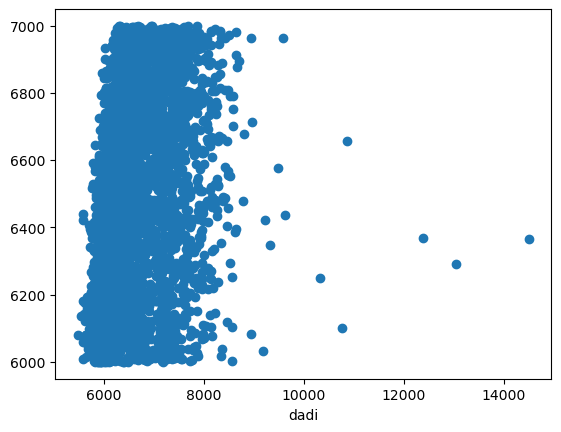

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(preproc['training']['predictions']['dadi_rep1_N_recover'], preproc['training']['targets']['simulated_params_N_recover'])
plt.xlabel("dadi")
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

# Select the columns for pairplot from the DataFrame
data = preproc['training']['predictions'][['dadi_rep1_N0', 'dadi_rep1_Nb', 'dadi_rep1_N_recover', 'dadi_rep1_t_bottleneck_end']]

# Ensure the input data is a DataFrame (sanity check)
if not isinstance(data, pd.DataFrame):
    raise ValueError("Input to sns.pairplot must be a DataFrame.")

# Create the pairplot
sns.pairplot(data)


KeyboardInterrupt: 

In [15]:
import pandas as pd

# Count rows with at least one NaN
rows_with_nan = preproc['training']['predictions'].isna().any(axis=1).sum()
print(f"Number of rows with at least one NaN: {rows_with_nan}")


Number of rows with at least one NaN: 0


In [16]:
import pandas as pd

# Assuming preproc['training']['predictions'] is a DataFrame
predictions_df = preproc['training']['predictions']

# Count rows with at least one NaN value
rows_with_nan = predictions_df.isna().any(axis=1).sum()

print(f"Number of rows with at least one NaN value: {rows_with_nan}")


Number of rows with at least one NaN value: 0


In [17]:
preproc['training']['predictions']['moments_rep1_N0']

0       8.387929e+03
1       9.731171e+03
2       8.726272e+03
3       8.832170e+03
4       1.959431e+05
            ...     
3995    7.197921e+07
3996    8.153790e+03
3997    1.344418e+07
3998    1.221511e+07
3999    9.335457e+03
Name: moments_rep1_N0, Length: 4000, dtype: float64

In [18]:
np.max(preproc['training']['targets']['simulated_params_N0'])

9999

In [19]:
np.min(preproc['training']['targets']['simulated_params_N0'])

8000

In [20]:
preproc['training']['targets']['simulated_params_N0']

0       8320
1       9673
2       8660
3       8746
4       8888
        ... 
3995    8020
3996    8133
3997    9278
3998    9303
3999    9375
Name: simulated_params_N0, Length: 4000, dtype: int64

In [21]:
preproc['training']['predictions']['dadi_rep1_N0']

0       7.418959e+07
1       9.735685e+03
2       8.730041e+03
3       7.693512e+07
4       8.980357e+03
            ...     
3995    8.078845e+03
3996    7.264474e+07
3997    9.268948e+03
3998    7.990525e+07
3999    9.534565e+06
Name: dadi_rep1_N0, Length: 4000, dtype: float64

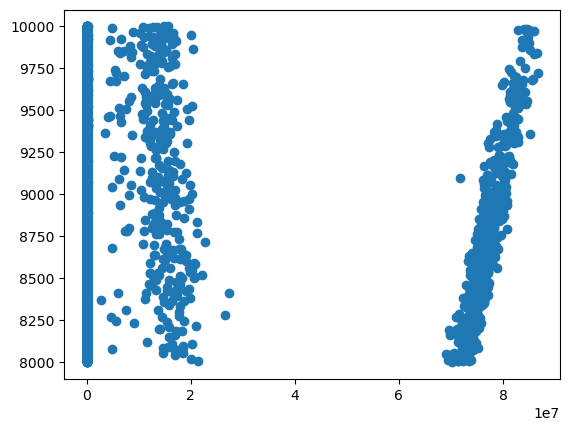

In [22]:
import matplotlib.pyplot as plt
plt.scatter(preproc['training']['predictions']['moments_rep1_N0'], preproc['training']['targets']['simulated_params_N0'])
# Set the zoomed-in range for the axes
# # Show the zoomed-in plot
# plt.show()
plt.show()

In [23]:
with open('/projects/kernlab/akapoor/Demographic_Inference/moments_dadi_features/software_inferences_sim_810.pkl', 'rb') as f:
    a = pickle.load(f)

In [24]:
a['simulated_params']

{'N0': 8636,
 'Nb': 4680,
 'N_recover': 6822,
 't_bottleneck_start': 1935,
 't_bottleneck_end': 869}

In [26]:
a['opt_params_dadi']

[{'N0': 8625.937457410775,
  'Nb': 4836.681274768978,
  'N_recover': 6662.555496122317,
  't_bottleneck_end': 959.4336049994249,
  'll': 236.4323728264426},
 {'N0': 8625.93167070637,
  'Nb': 4836.621857356924,
  'N_recover': 6662.64229204143,
  't_bottleneck_end': 959.4498287538943,
  'll': 236.43236322834673}]

## Postprocessing

In [27]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/postprocessing.py \
    --config_file $CONFIG_FILEPATH \
    --training_features_filepath $SIM_DIRECTORY/training_features.csv \
    --training_targets_filepath $SIM_DIRECTORY/training_targets.csv \
    --validation_features_filepath $SIM_DIRECTORY/validation_features.csv \
    --validation_targets_filepath $SIM_DIRECTORY/validation_targets.csv \
    --sim_directory $SIM_DIRECTORY



Processing training data:
===> Normalizing the data.

Processing validation data:
===> Normalizing the data.
Postprocessing dict keys: dict_keys(['normalization', 'predictions', 'normalized_predictions', 'targets', 'normalized_targets'])
Postprocessing complete!


In [28]:
with open(os.path.join('/projects/kernlab/akapoor/Demographic_Inference',f'{SIM_DIRECTORY}', 'postprocessing_results.pkl'), 'rb') as f:
    post = pickle.load(f)

In [29]:
post['training']['normalized_predictions']['dadi_rep1_t_bottleneck_end']

0       2.569987e+06
1       1.753907e+00
2       2.564052e+01
3       2.665095e+06
4       3.247716e+01
            ...     
3995    4.418042e+01
3996    2.516472e+06
3997   -3.418987e+00
3998    2.767984e+06
3999    1.744024e+01
Name: dadi_rep1_t_bottleneck_end, Length: 4000, dtype: float64

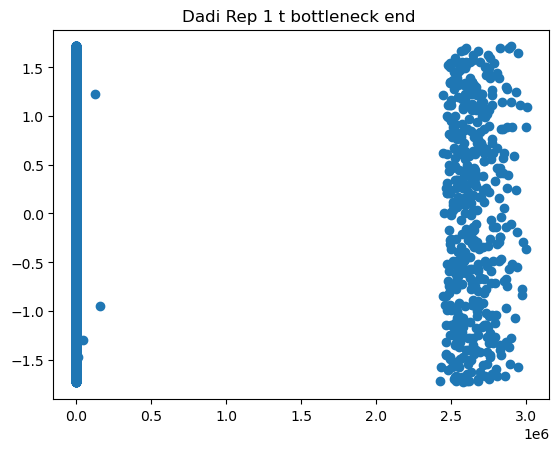

In [30]:
plt.figure()
plt.title("Dadi Rep 1 t bottleneck end ")
plt.scatter(post['training']['normalized_predictions']['dadi_rep1_t_bottleneck_end'], post['training']['normalized_targets']['simulated_params_t_bottleneck_end'])
plt.show()

## Calculate the MSE for each analysis type and for each stage.

In [31]:
post['training']['normalized_predictions']

,dadi_rep1_N0,moments_rep1_N0,moments_rep1_FIM_element_0,moments_rep1_FIM_element_1,moments_rep1_FIM_element_2,moments_rep1_FIM_element_3,moments_rep1_FIM_element_4,moments_rep1_FIM_element_5,dadi_rep1_Nb,moments_rep1_Nb,...,dadi_rep2_Nb,moments_rep2_Nb,dadi_rep2_N_recover,moments_rep2_N_recover,dadi_rep2_t_bottleneck_end,moments_rep2_t_bottleneck_end,momentsLD_N0,momentsLD_Nb,momentsLD_N_recover,momentsLD_t_bottleneck_end
0,128484.548271,-1.060139,0.276726,-0.254005,0.282219,0.398799,-0.201950,-0.287445,231284.657653,10.562516,...,-1.747216,-1.599009,-0.153698,-0.235096,7.494282e+00,7.702662,-0.661291,2.354240,4.795701,-9.367692
1,1.274244,1.266424,0.276723,-0.254005,0.282217,0.398799,-0.201949,-0.287449,-0.946047,-0.745117,...,-0.946046,-0.750044,2.325414,2.162185,1.753888e+00,1.908138,1.486016,1.585594,4.520429,-9.851780
2,-0.467582,-0.474110,0.276725,-0.254005,0.282219,0.398799,-0.201950,-0.287445,11.629118,11.617367,...,0.045611,11.614844,1.237539,-0.281639,-2.496184e+00,25.381922,0.799337,11.305435,-2.702889,-5.079854
3,133239.940043,-0.290690,0.276725,-0.254005,0.282219,0.398799,-0.201950,-0.287445,239844.362843,11.947524,...,-1.340903,-1.125886,9.051303,7.064276,-9.973188e+00,-9.754434,-0.855719,4.663410,-0.828335,-12.603631
4,-0.034023,323.794864,0.276725,-0.253951,0.282218,0.398785,-0.202045,-0.287399,12.409525,232.698767,...,1.811557,12.394964,-1.115547,-1.604347,4.986360e+00,32.062344,0.367382,-6.446438,-0.827639,8.194831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1.595487,124656.059954,0.276726,-0.254088,0.282219,-2.212535,-0.201951,-0.287446,9.598888,224393.378682,...,9.598882,9.588279,-0.996184,-1.015582,4.418019e+01,43.525858,-1.175257,0.907074,6.545274,-8.368436
3996,125808.791706,-1.465679,0.276725,-0.254005,0.282219,0.398799,-0.201950,-0.287446,226468.295837,9.832543,...,226468.295837,-0.499478,2.648216,1.371838,2.516472e+06,-3.525929,-1.469465,3.442878,6.394211,-8.754525
3997,0.465832,23270.415725,-2.580601,2.021763,-2.813152,0.305398,2.329253,3.749665,-2.090677,16.747659,...,-2.090686,-1.890155,0.635043,0.352147,-3.419041e+00,-3.203973,-0.237831,34.892516,-2.113856,28.180965
3998,138384.372290,21141.610966,-1.877287,1.827834,-1.892230,0.318147,1.528427,1.704327,249104.340888,16.988217,...,9.384874,7.581413,-1.020409,-1.021691,3.342080e+01,30.207058,0.251900,-3.593022,0.781205,1.556069


In [32]:
post['training']['normalized_predictions']['dadi_rep1_N0']

0       128484.548271
1            1.274244
2           -0.467582
3       133239.940043
4           -0.034023
            ...      
3995        -1.595487
3996    125808.791706
3997         0.465832
3998    138384.372290
3999     16498.761818
Name: dadi_rep1_N0, Length: 4000, dtype: float64

In [33]:
mean_squared_error(post['training']['normalized_predictions']['dadi_rep1_N0'], post['training']['normalized_targets']['simulated_params_N0'])

2101117853.5863469

In [34]:
np.min(post['training']['normalized_predictions']['dadi_rep1_N0'])

-1.9496130912894736

In [35]:
mean_squared_error(post['training']['normalized_predictions']['dadi_rep1_Nb'], post['training']['normalized_targets']['simulated_params_Nb'])

6706283150.592062

In [36]:
np.max(post['training']['normalized_predictions']['dadi_rep1_Nb'])

270249.4035961512

In [37]:
post['training']['normalized_targets']['simulated_params_Nb']

0       0.103923
1       1.427210
2       1.368320
3       0.360267
4       0.862561
          ...   
3995   -0.460726
3996   -1.326751
3997   -0.173205
3998   -0.374123
3999    1.538061
Name: simulated_params_Nb, Length: 4000, dtype: float64

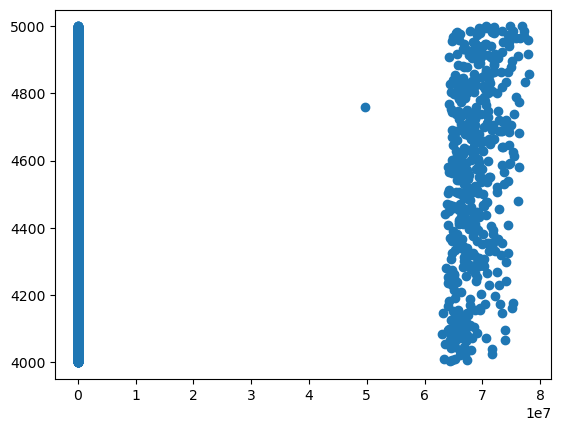

In [38]:
import matplotlib.pyplot as plt
plt.scatter(preproc['training']['predictions']['dadi_rep1_Nb'], preproc['training']['targets']['simulated_params_Nb'])

In [39]:
def plot_mse_and_sem(mse_results, sem_results, title, parameters):
    """
    Create a grouped bar plot showing MSE values with error bars for each parameter and analysis type.
    
    Parameters:
    -----------
    mse_results : dict
        Dictionary containing MSE values for each analysis type and parameter
    sem_results : dict
        Dictionary containing SEM values for each analysis type and parameter
    title : str
        Title for the plot
    parameters : list
        List of parameter names to plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create figure and axis with clean style
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Number of parameter groups and analysis types
    n_parameters = len(parameters)
    n_analyses = len(mse_results.keys())
    
    # Width of each bar and positions of the bars
    bar_width = 0.25
    index = np.arange(n_parameters)
    
    # Colors for different analysis types - using more distinct colors
    colors = ['#2ecc71', '#3498db', '#e74c3c']  # green, blue, red
    
    # Plot bars for each analysis type
    for i, (analysis_type, color) in enumerate(zip(mse_results.keys(), colors)):
        mse_values = []
        sem_values = []
        for param in parameters:
            mse_values.append(mse_results[analysis_type].get(param, 0))
            sem_values.append(sem_results[analysis_type].get(param, 0))
        
        positions = index + (i - 1) * bar_width
        bars = ax.bar(positions, mse_values, bar_width,
                     label=analysis_type, color=color, alpha=0.8)
        
        # Add error bars
        ax.errorbar(positions, mse_values, yerr=sem_values,
                   fmt='none', color='black', capsize=5)
    
    # Customize the plot
    ax.set_ylabel('Mean Squared Error (MSE)', fontsize=10)
    ax.set_title(title, fontsize=12, pad=20)
    ax.set_xticks(index)
    ax.set_xticklabels(parameters, fontsize=10)
    
    # Add legend with better positioning
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)
    
    # Add grid with light color
    ax.yaxis.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig

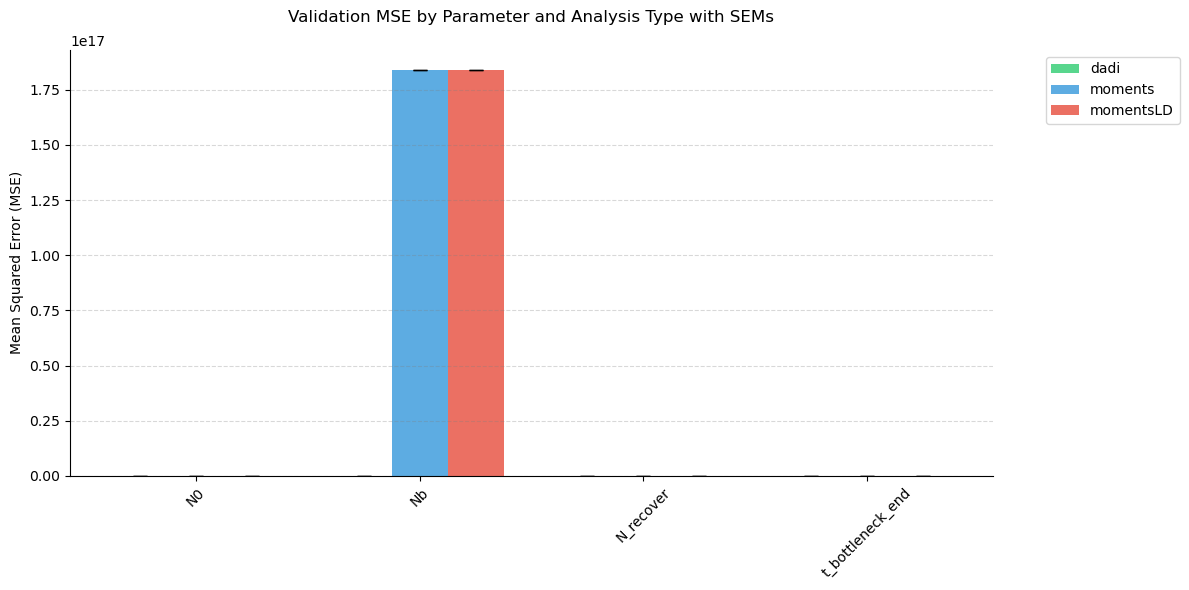

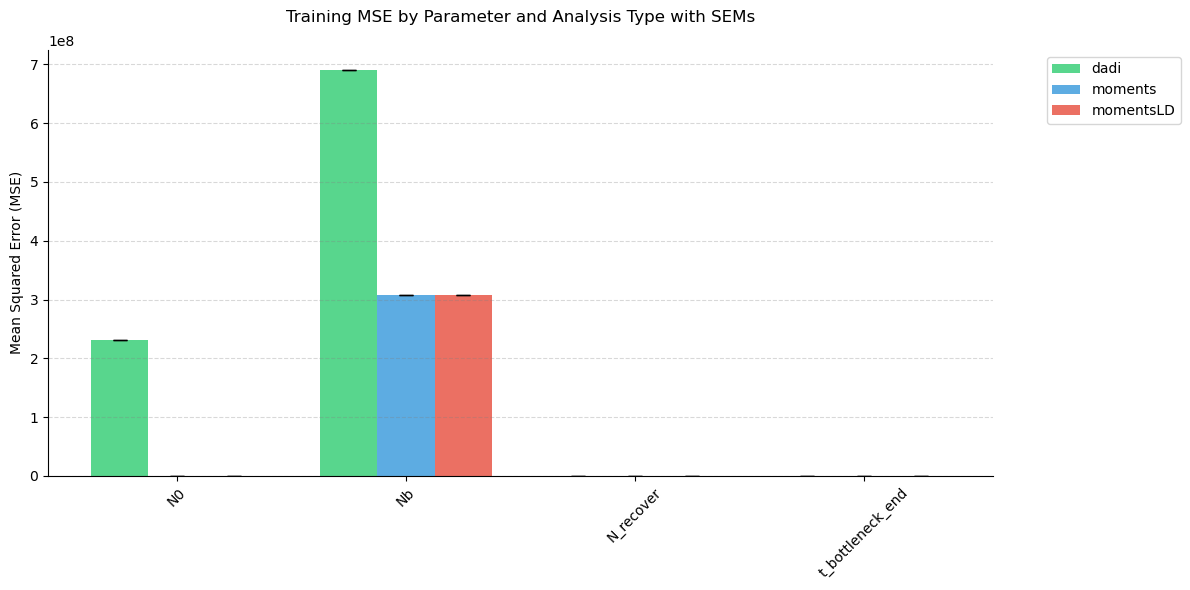

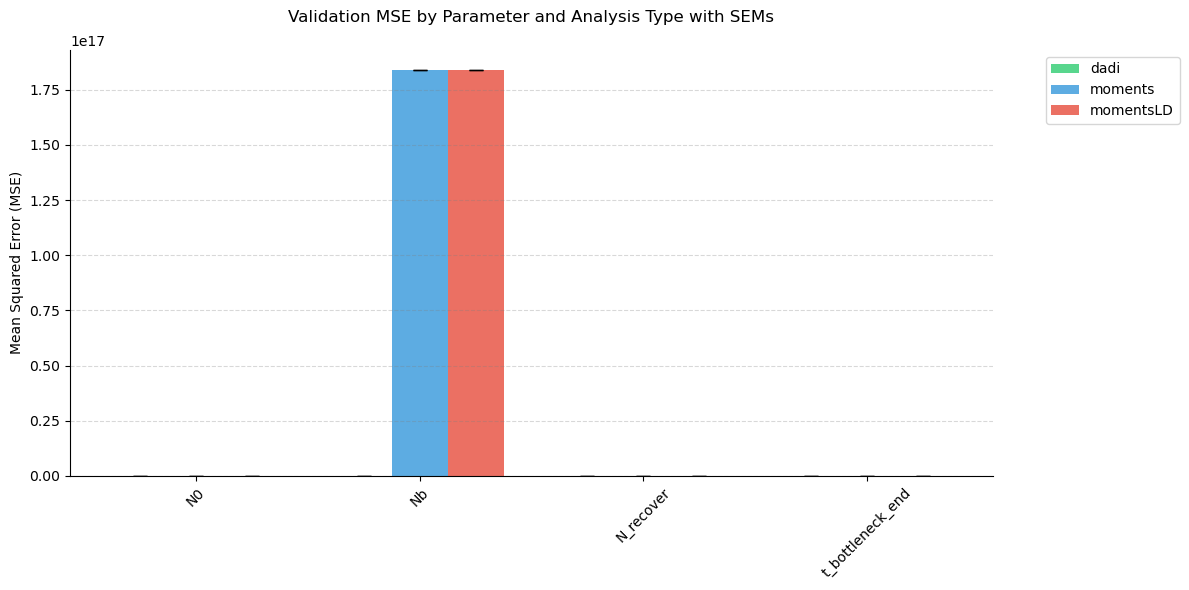

In [40]:
# Updated function to handle underscores in parameter names correctly
def calculate_mse_and_sem(post, key):
    predictions = post[key]['normalized_predictions']
    targets = post[key]['normalized_targets']
    mse_results = {}
    sem_results = {}

    for analysis_type in ['dadi', 'moments', 'momentsLD']:
        mse_values = {}
        sem_values = {}
        for column in predictions.columns:
            if column.startswith(analysis_type):
                # Extract parameter name after the last '_'
                param_name = "_".join(column.split('_')[-2:]) if 't_split' in column else column.split('_')[-1]
                target_column = f"simulated_params_{param_name}"
                if target_column in targets.columns:
                    mse = mean_squared_error(targets[target_column], predictions[column])
                    mse_values[param_name] = mse
                    sem = np.std(targets[target_column] - predictions[column]) / np.sqrt(len(targets[target_column]))
                    sem_values[param_name] = sem
        if mse_values:
            mse_results[analysis_type] = mse_values
            sem_results[analysis_type] = sem_values
    return mse_results, sem_results

# Parameters list
# parameters = ['Na', 'N1', 'N2', "t_split"]
parameters = experiment_config['parameters_to_estimate']

# Recalculate MSE and SEM for training and validation with the updated function
training_mse, training_sem = calculate_mse_and_sem(post, 'training')
validation_mse, validation_sem = calculate_mse_and_sem(post, 'validation')

# Re-plot with the fixed parameter handling
plot_mse_and_sem(training_mse, training_sem, "Training MSE by Parameter and Analysis Type with SEMs", parameters)
plot_mse_and_sem(validation_mse, validation_sem, "Validation MSE by Parameter and Analysis Type with SEMs", parameters)

In [41]:
training_mse

{'dadi': {'N0': 231970816.25561985, 'Nb': 690322346.8665881},
 'moments': {'N0': 68.90109253684578, 'Nb': 308292074.65493345},
 'momentsLD': {'N0': 68.90109253684578, 'Nb': 308292074.65493345}}

In [42]:
validation_mse

{'dadi': {'N0': 138414631.17750353, 'Nb': 385574847.32303786},
 'moments': {'N0': 152.2146763862601, 'Nb': 1.8389841749703555e+17},
 'momentsLD': {'N0': 152.2146763862601, 'Nb': 1.8389841749703555e+17}}

In [43]:
post['training']['predictions'].columns

Index(['dadi_rep1_N0', 'moments_rep1_N0', 'moments_rep1_FIM_element_0',
       'moments_rep1_FIM_element_1', 'moments_rep1_FIM_element_2',
       'moments_rep1_FIM_element_3', 'moments_rep1_FIM_element_4',
       'moments_rep1_FIM_element_5', 'dadi_rep1_Nb', 'moments_rep1_Nb',
       'dadi_rep1_N_recover', 'moments_rep1_N_recover',
       'dadi_rep1_t_bottleneck_end', 'moments_rep1_t_bottleneck_end',
       'dadi_rep2_N0', 'moments_rep2_N0', 'moments_rep2_FIM_element_0',
       'moments_rep2_FIM_element_1', 'moments_rep2_FIM_element_2',
       'moments_rep2_FIM_element_3', 'moments_rep2_FIM_element_4',
       'moments_rep2_FIM_element_5', 'dadi_rep2_Nb', 'moments_rep2_Nb',
       'dadi_rep2_N_recover', 'moments_rep2_N_recover',
       'dadi_rep2_t_bottleneck_end', 'moments_rep2_t_bottleneck_end',
       'momentsLD_N0', 'momentsLD_Nb', 'momentsLD_N_recover',
       'momentsLD_t_bottleneck_end'],
      dtype='object')

## Extracting Features

In [44]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/extracting_features.py \
 --postprocessing_results_filepath $SIM_DIRECTORY/postprocessing_results.pkl \
 --sim_directory $SIM_DIRECTORY

dict_keys(['parameter_names', 'target_names', 'training', 'validation'])
Training features shape: (4000, 32)
Validation features shape: (1000, 32)
Training targets shape: (4000, 4)
Validation targets shape: (1000, 4)


## Linear Evaluation

In [46]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type standard

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
Initializing LinearRegression with kwargs={}
PREDICTIONS SHAPE TRAINING: (4000, 4)
[0.81651071 1.03273801 0.79094069 ... 0.841397   0.29226714 0.54866889]
[1.35948127e+00 4.15439881e-01 7.42586500e-01 2.02320216e-01
 5.80290439e-01 8.73753546e-01 4.43147849e-01 3.40946318e-01
 6.61073285e-01 9.13643381e-01 1.30225602e+00 7.57848088e-01
 2.75762337e-01 1.57572287e-01 5.24771175e-01 5.57480699e-01
 1.32453564e+00 9.83747240e-01 4.60383232e-01 1.15166548e+00
 9.30433913e-01 2.83639446e-01 2.40619207e-01 7.16035474e-01
 7.19451581e-01 6.99879450e-01 3.97750036e-01 6.03596793e-01
 6.84842120e-01 4.00698464e-01 9.01328779e-01 1.20240536e+00
 1.67411082e+00 1.12748592e+00

### Ridge

In [ ]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type ridge

### Lasso

In [63]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type lasso

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.643e+02, tolerance: 3.220e-01
  model = cd_fast.enet_coordinate_descent(
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

### Elastic Net

In [ ]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type elasticnet

## Random Forest

In [48]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/random_forest_evaluation.py \
    --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
    --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
    --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
    --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
    --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False

No hyperparameters specified. Running RandomizedSearchCV to find best hyperparameters...

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters found via RandomizedSearchCV: {'random_state': 123, 'n_estimators': 300, 'min_samples_split': 10, 'max_depth': None}

Initializing RandomForestRegressor with kwargs={'n_estimators': 300, 'max_depth': None, 'random_state': 123, 'min_samples_split': 10}

Random Forest predictions shape (training): (4000, 4)
Random Forest predictions shape (validation): (1000, 4)

[0.36443587 0.31345792 0.02933309 ... 0.17546089 0.09232295 0.10685764]
[1.00104428 0.14722396 1.21510322 0.21364378 0.18510522 0.76583

## XGBoost

In [49]:
 !python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/xgboost_evaluation.py \
    --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
    --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
    --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
    --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
    --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False

No XGBoost hyperparameters specified. Running RandomizedSearchCV to find best hyperparameters...

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters found via RandomizedSearchCV: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

Initializing XGBRegressor with kwargs={'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'reg_lambda': 1, 'reg_alpha': 0}

XGBoost predictions shape (training): (4000, 4)
XGBoost predictions shape (validation): (1000, 4)

[0

## Neural Network

In [ ]:
    # parser.add_argument("--experiment_directory", type=str, required=True)
    # parser.add_argument("--model_config_file", type=str, required=True)
    # parser.add_argument("--features_file", type=str, required=True)
    # parser.add_argument("--color_shades", type=str, required=True)
    # parser.add_argument("--main_colors", type=str, required=True)

In [ ]:
preproc['training']['predictions']

In [ ]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/setup_trainer.py \
    --experiment_directory $EXPERIMENT_DIRECTORY \
    --model_config_file $MODEL_CONFIG_FILEPATH \
    --features_file $SIM_DIRECTORY/features_and_targets.pkl \
    --color_shades $SIM_DIRECTORY/color_shades.pkl \
    --main_colors $SIM_DIRECTORY/main_colors.pkl

In [ ]:
preproc['training']['predictions'].columns

In [ ]:
import torch
print("Is CUDA available?", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")